In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np

import pandas as pd
from matplotlib.ticker import LogFormatter 
from scipy.optimize import curve_fit
from pathlib import Path
import matplotlib.colors
from matplotlib import ticker, cm
import pickle

from scipy.stats import norm
#%matplotlib notebook

import seaborn as sns

[400, 700]
[500, 700]
[550, 700]
[600, 700]
[400, 600]
[500, 600]


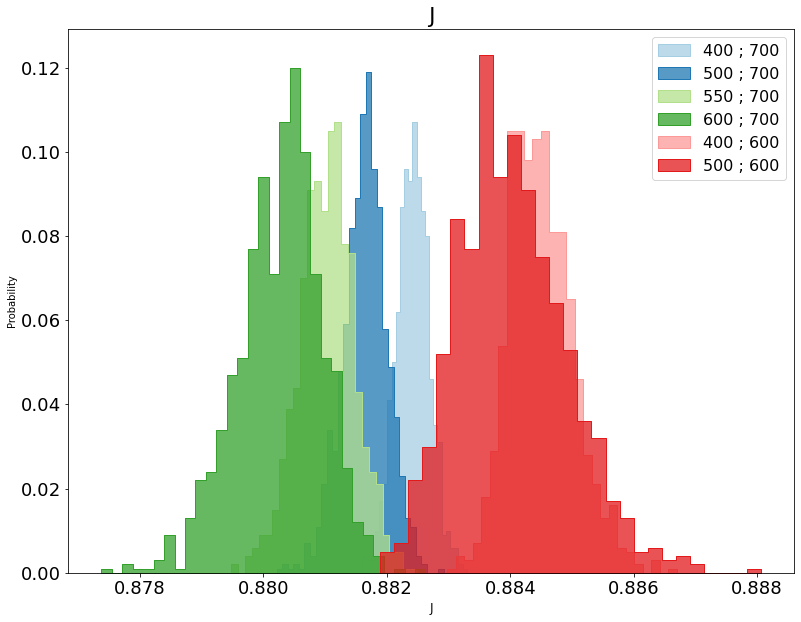

In [9]:
data_np = np.loadtxt("CPP_3D/Results/LongerIteration1/LongChains.txt", skiprows=0)


data_np = np.loadtxt("CPP_3D/Results/Long/LongChains.txt", skiprows=0)
y= np.argsort(data_np[:, 1],kind='mergesort')
data_np=data_np[y]


J_min = 0.872
#J_max = 0.885
J_max = 0.89


J_min = 0.875
J_max = 0.888



data_np = data_np[data_np[:,1]<=J_max]
data_np = data_np[data_np[:,1]>=J_min]

#data_np = np.vstack([data_np[data_np[:,1]==J_max], data_np[data_np[:,1]==J_min]] )
 

y= np.argsort(data_np[:, 1],kind='mergesort')
data_np=data_np[y]

pairs = [[400,700], [500,700], [550,700], [600, 700],[400,600], [500,600]  ]
#pairs = [[5000, 1000], [5000, 2000], [1000,2000]]

 
fig = plt.figure(figsize=(13, 10))
ax = fig.add_subplot(111)
 
plt.title("J",fontsize=22)
c = 0 
#custom_palette =sns.color_palette("RdPu",  len(pairs)) #sns.color_palette("Paired", len(pairs))
#sns.set_palette("Paired")
custom_palette = sns.color_palette("Paired", len(pairs))

L_plot = []
BC_plot = []
err_plot = []
J_plot = []
J_err_plot = []

nu = 1/2
for pair in pairs:
    
    print(pair)
    data_l1 = data_np[data_np[:,0]==pair[0]]
    data_l2 = data_np[data_np[:,0]==pair[1]]
    bc_1 = []
    errs_1=[]
    bc_2 = []
    errs_2 = []    
    
    crit_J = []
    crit_bc = []
    for step in range(1000):
        bc_1 = []
        errs_1=[]
        bc_2 = []
        errs_2 = [] 
        J_l1 =  np.unique(data_l1[:, 1])
        for J in J_l1 :

            data_l = data_l1[data_l1[:,1]==J]
            ind = np.argmin(data_l[:, 4])
            data_l = data_l[ind, :]
            r2 = norm.rvs(data_l[3], data_l[4], size =  10 )
            #m4 = norm.rvs(data_l[17], data_l[18], size =  1000 )
            #cum_1 = 1 - m4/3/m2/m2
            cum_1 = r2/np.power(pair[0], 2*nu)
            bc_1.append(np.mean(cum_1))
            errs_1.append(np.std(cum_1))

        J_l2 =  np.unique(data_l2[:, 1])
        for J in J_l2 :
            data_l = data_l2[data_l2[:,1]==J]
            ind = np.argmin(data_l[:, 4])
            data_l = data_l[ind, :]
            r2 = norm.rvs(data_l[3], data_l[4], size =  10 )
            #m4 = norm.rvs(data_l[17], data_l[18], size =  1000 )
            #cum_2 = 1 - m4/3/m2/m2
            cum_2 = r2/np.power(pair[1], 2*nu)
            bc_2.append(np.mean(cum_2))
            errs_2.append(np.std(cum_2))
            
        #print(J_l1, bc_1)
        cov1 = np.zeros((len(bc_1), len(bc_1)))
        np.fill_diagonal(cov1, np.square(errs_1))
        cov2 = np.zeros((len(bc_2), len(bc_2)))
        np.fill_diagonal(cov2, np.square(errs_2))
        
        A1 = np.vstack([J_l1, np.ones(len(J_l1))]).T
        m1, c1 = np.linalg.lstsq(A1, bc_1, rcond=None)[0]
        
        #print(cov1.shape, A1.shape)
        CovMatrix = cov1
        X = A1
        CovMatrix_inv = np.linalg.inv(CovMatrix)
        X_transose = X.transpose()
        X_t_Cov = X_transose.dot(CovMatrix_inv) #np.matmul(X_transose, CovMatrix)
        First_part = X_t_Cov.dot(X) 
        First_part_inv =  np.linalg.inv(First_part  )
        FP_X_t = First_part_inv.dot(X_transose)
        y = bc_1
        Result = np.matmul( FP_X_t.dot(CovMatrix_inv), y )
        #print(Result, m1, c1)
        m1, c1 = Result
        
        
        A2 = np.vstack([J_l2, np.ones(len(J_l2))]).T
        m2, c2 = np.linalg.lstsq(A2, bc_2, rcond=None)[0]
        
        CovMatrix = cov2
        X = A2
        CovMatrix_inv = np.linalg.inv(CovMatrix)
        X_transose = X.transpose()
        X_t_Cov = X_transose.dot(CovMatrix_inv) #np.matmul(X_transose, CovMatrix)
        First_part = X_t_Cov.dot(X) 
        First_part_inv =  np.linalg.inv(First_part  )
        FP_X_t = First_part_inv.dot(X_transose)
        y = bc_2
        Result = np.matmul( FP_X_t.dot(CovMatrix_inv), y )
        #print(Result, m1, c1)
        m2, c2 = Result        
        
        
        A = np.array([[1, -m1], [1, -m2]])
        b = np.array([c1, c2])
        
        xy = np.dot(np.linalg.inv(A),b)
        
        crit_bc.append(xy[0])
        crit_J.append(xy[1])
 
    if 700 in pair:
        if (pair[0]==700):
            L_plot.append(pair[1])
        else:
            L_plot.append(pair[0])
        BC_plot.append(np.mean(crit_bc))
        err_plot.append(np.std(crit_bc))
        J_plot.append(np.mean(crit_J))
        J_err_plot.append(np.std(crit_J))
    
    sns.histplot(data=crit_J,label = str(pair[0])+ " ; " +str(pair[1]), color=custom_palette[c],stat="probability",multiple="stack",element="step" )
    c+=1
 
plt.legend(fontsize=16)
plt.tick_params(axis='x', labelsize=18) 
plt.tick_params(axis='y', labelsize=18)
plt.xlabel("J", fontsize=12)
#plt.xlim(right=0.875)
plt.savefig("Thesis/Images/radius_hist_cov_3D.png")

In [10]:
A2 = np.vstack([1/np.array(L_plot), np.ones(len(1/np.array(L_plot)))]).T
m2, c2 = np.linalg.lstsq(A2, BC_plot, rcond=None)[0]

m1, c1 = m2, c2

A2 = np.vstack([1/np.array(L_plot), np.ones(len(1/np.array(L_plot)))]).T
m2, c2 = np.linalg.lstsq(A2, J_plot, rcond=None)[0]

m2, c2

(2.4265771059116665, 0.8764940801990512)

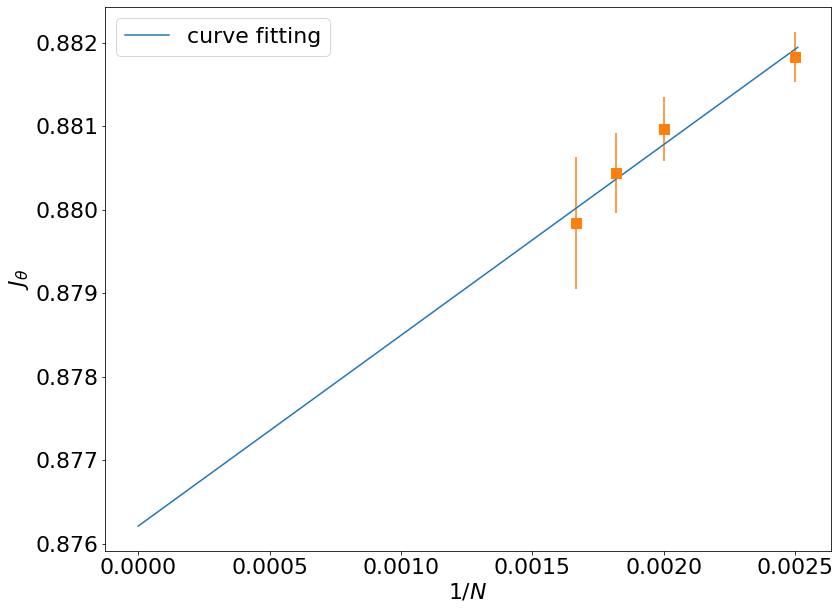

In [5]:
fig = plt.figure(figsize=(13, 10))
ax = fig.add_subplot(111)

xfit = np.array([0,0.002510511])
jfit = c2+m2*xfit
plt.plot(xfit,jfit, label = "curve fitting")

xfit = np.array([0,0.00251020511])
jfit = c1+m1*xfit
 

plt.errorbar(1/np.array(L_plot), J_plot, yerr=J_err_plot, fmt="s", ms = 10 )
plt.xlabel(r"$1/N$", fontsize = 22)
plt.ylabel(r"$J_{\theta}$", fontsize = 22)
#axes[1].set_xlim([0,0.0011])

plt.tick_params(axis='x', labelsize=22) 
plt.tick_params(axis='y', labelsize=22) 

plt.legend(fontsize=22) 
plt.savefig("Thesis/Images/criticalr2_3D.png", bbox_inches='tight') 

In [6]:
np.mean(BC_plot)

1.918266947965852